# Traffic Sign Classification Project

---
## Step 0: Import Packages & Load Datasets

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import time
import os
from textwrap import wrap

In [2]:
training_file = 'traffic_signs_data/train.p'
validation_file= 'traffic_signs_data/valid.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---
## Step 1: Dataset Exploration

### Dataset Summary

In [3]:
print('Number of training examples =', len(X_train))
print('Number of validation examples =', len(X_valid))
print('Number of testing examples =', len(X_test))
print('Image data shape =', X_train[0].shape)
print('Number of classes =', len(np.unique(y_train)))

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization

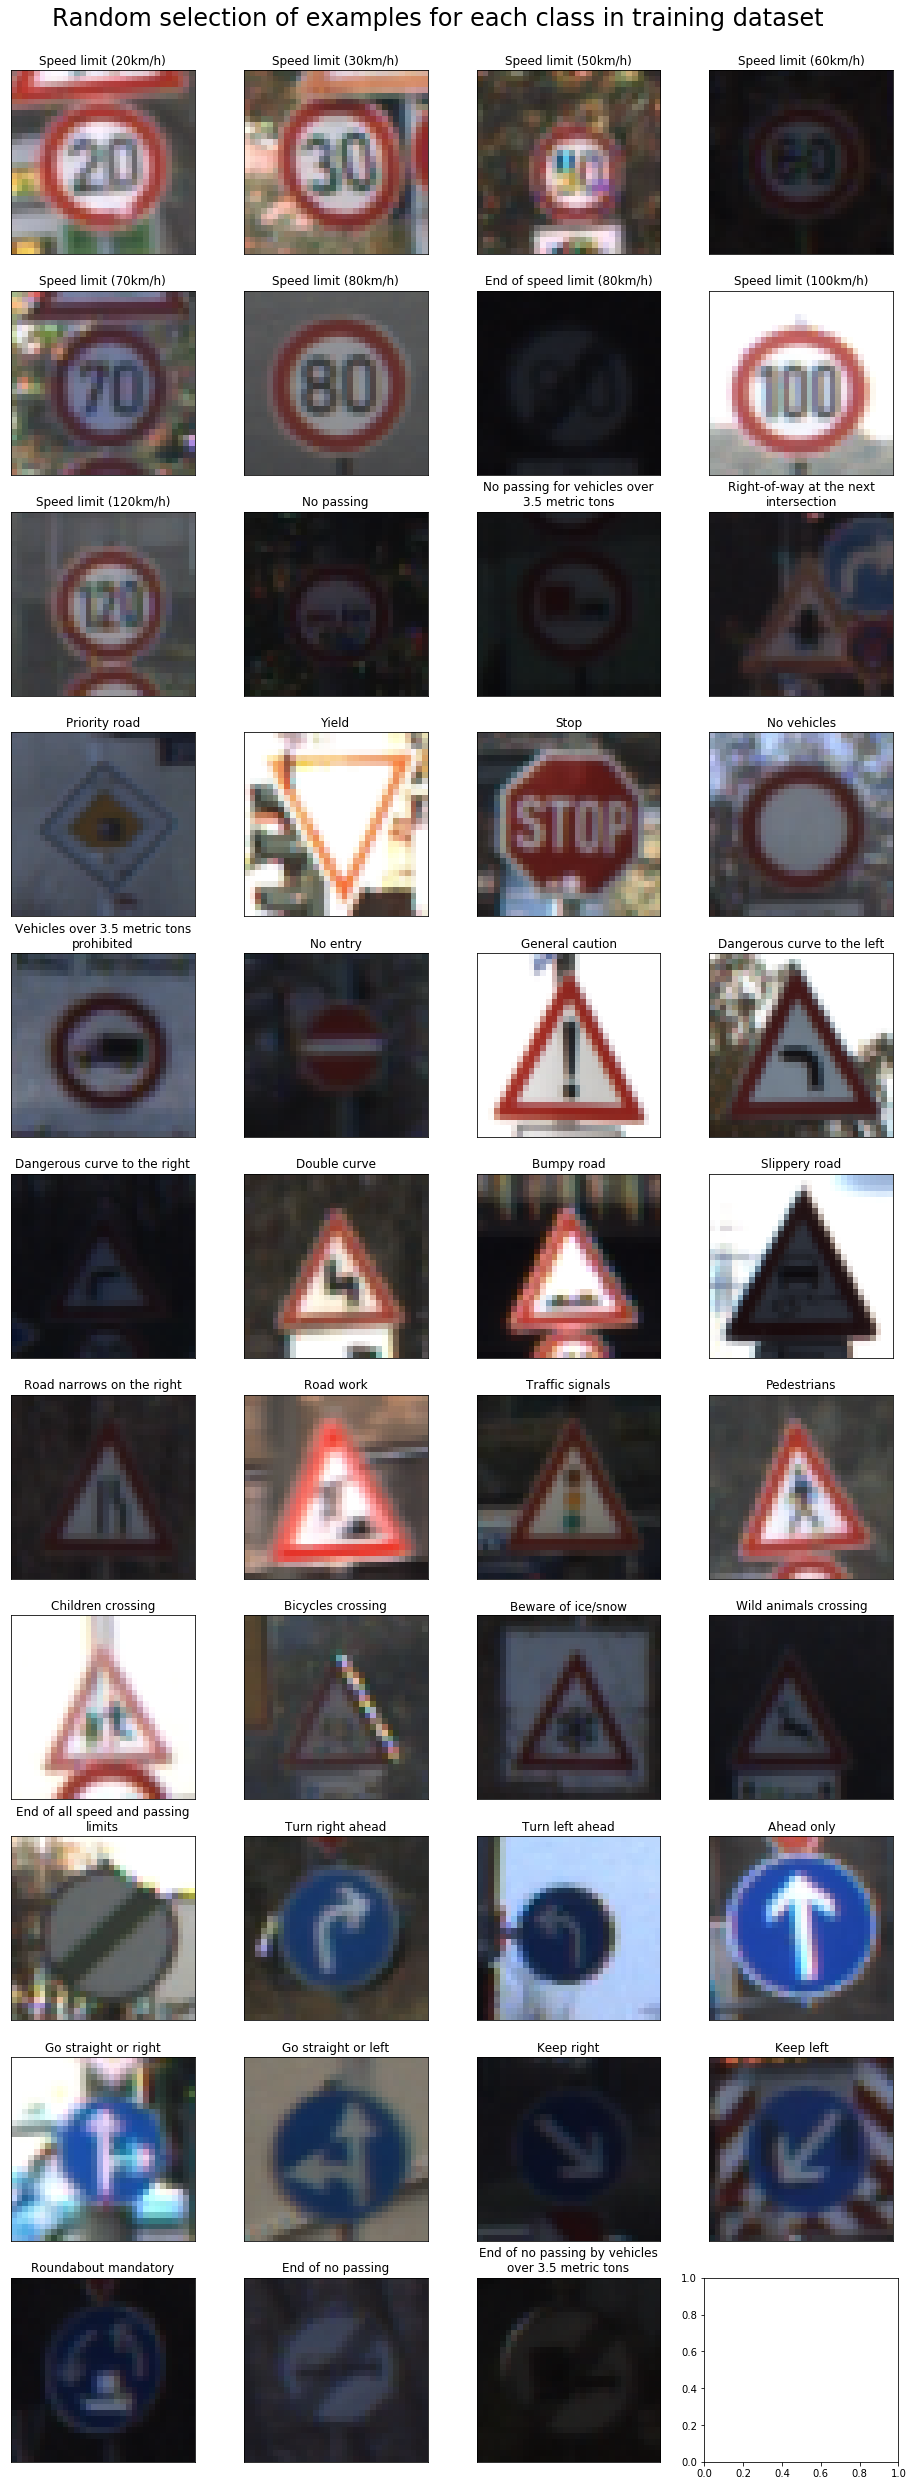

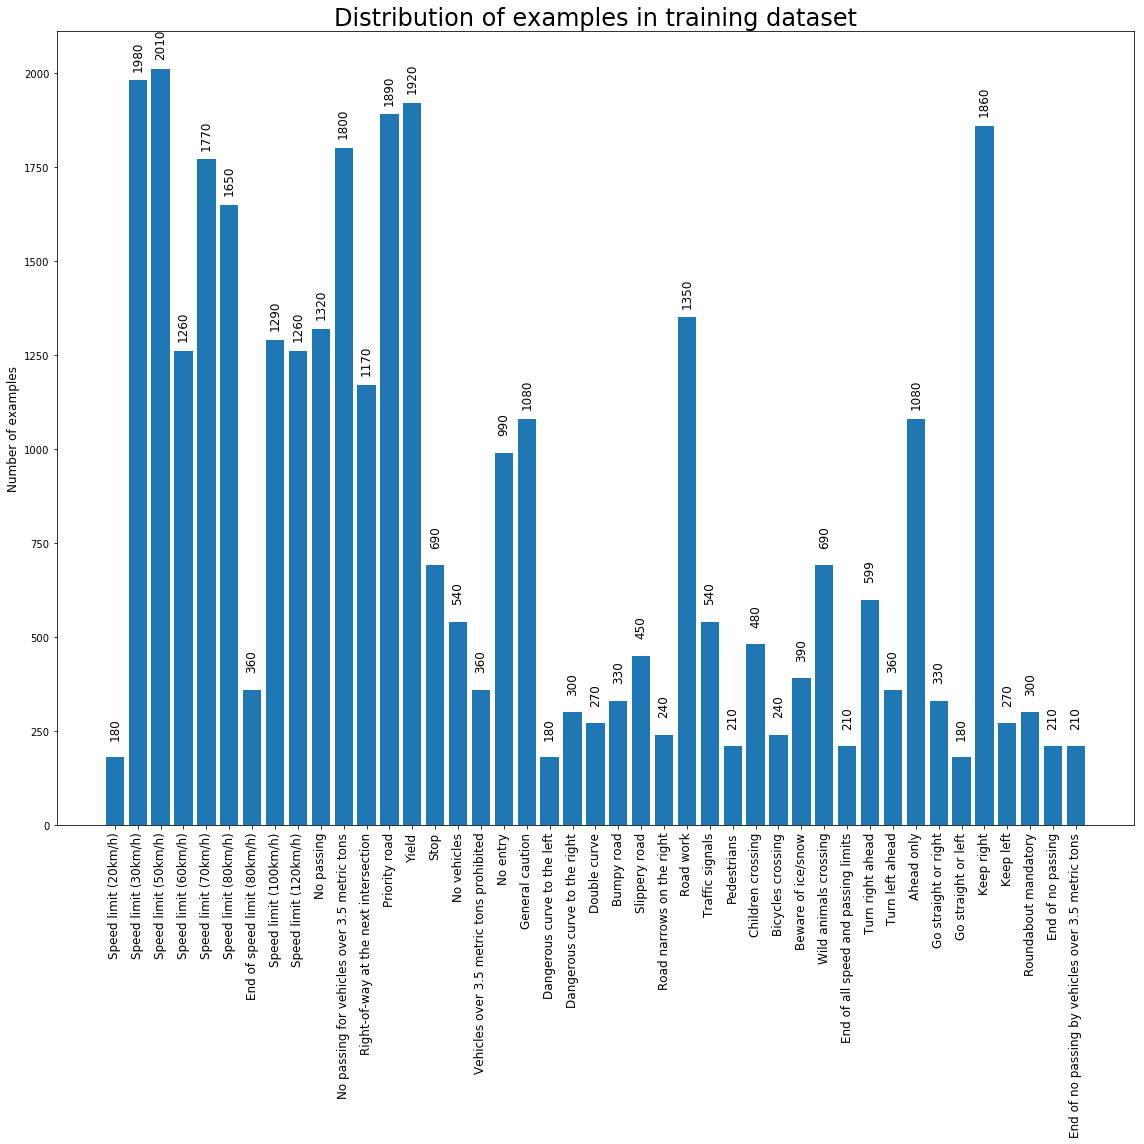

In [4]:
# Load file containing class IDs and sign names
signnames = np.genfromtxt('signnames.csv', dtype = ['i2', 'U50'], delimiter = ',', names = True)

# Plot random selection of examples for each class in training dataset
fig1, axes1 = plt.subplots(11, 4, figsize = (16, 44))

fig1.suptitle('Random selection of examples for each class in training dataset', fontsize = 24, y = 0.9)

for ax1, classid in zip(axes1.flat, signnames['ClassId']):
    index = np.random.choice(np.argwhere(y_train == classid).flatten()) # Find random example belonging to class ID
    ax1.imshow(X_train[index])
    ax1.set_title('\n'.join(wrap(signnames['SignName'][y_train[index]], width = 30)), fontsize = 12)
    ax1.set_xticks([])
    ax1.set_yticks([])

# Count number of examples per class ID in training dataset
examples = [len(np.argwhere(y_train == classid)) for classid in signnames['ClassId']]

# Plot bar chart distribution of examples in training dataset
fig2, ax2 = plt.subplots(figsize = (16, 16))

ax2.bar(signnames['ClassId'], examples)
ax2.set_title('Distribution of examples in training dataset', fontsize = 24)
ax2.set_xticks(signnames['ClassId'])
ax2.set_xticklabels(signnames['SignName'], fontsize = 12, rotation = 'vertical')
ax2.set_ylabel('Number of examples', fontsize = 12)

for patch, example in zip(ax2.patches, examples):
    ax2.text(patch.get_x() + patch.get_width()/2, patch.get_height() + 80,
            example, fontsize = 12, rotation = 'vertical', ha = 'center')

plt.tight_layout()

----

## Step 2: Design & Test Model Architecture

### Pre-processing & Generating Data

In [5]:
def preprocess(X):
    # Convert to grayscale
    X = 0.299*X[:, :, :, 0] + 0.587*X[:, :, :, 1] + 0.114*X[:, :, :, 2]

    # Normalize pixel values
    X = (X - 128.0)/128.0

    # Reshape images
    X = X.reshape(X.shape + (1,))

    return X

# NOTE: Numpy version 1.12.0 required for np.flip()

def flip(X, y, classids, faxis):
    for classid in classids:
        indexes = np.argwhere(y == classid).flatten() # Find examples belonging to class ID
        for index in indexes:
            X = np.append(X, [np.flip(X[index], axis = faxis)], axis = 0) # Flip sign
            y = np.append(y, [classid], axis = 0)
    
    return X, y

def rotate(X, y, classids):
    for classid in classids:
        indexes = np.argwhere(y == classid).flatten() # Find examples belonging to class ID
        for index in indexes:
            X = np.append(X, [np.flip(np.flip(X[index], 0), 1)], axis = 0) # Rotate sign 180 degrees
            y = np.append(y, [classid], axis = 0)
    
    return X, y

def symmetry(X, y, classids):
    
    X_new = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_new = np.empty([0], dtype = y.dtype)
    
    for classid_1, classid_2 in zip(*classids):
        indexes = np.argwhere(y == classid_1).flatten() # Find examples belonging to class ID
        for index in indexes:
            X_new = np.append(X_new, [np.flip(X[index], 1)], axis = 0) # Flip sign horizontally
            y_new = np.append(y_new, [classid_2], axis = 0) # Assign flipped sign to class ID of symmetric counterpart
    
    X = np.append(X, X_new, axis = 0)
    y = np.append(y, y_new, axis = 0)
    
    return X, y

In [6]:
# Pre-process datasets
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

# Classes that have >2000 examples in the training dataset do not have additional data generated for them
# to help even out distribution of examples per class

# Flip signs horizontally
classids_hor = np.array([9, 11, 15, 17, 18, 22, 26, 30, 35]) # Class IDs of signs that can be flipped vertically
X_train, y_train = flip(X_train, y_train, classids_hor, 1)

# Flip signs vertically
classids_ver = np.array([15]) # Class ID of sign that can be flipped vertically
X_train, y_train = flip(X_train, y_train, classids_ver, 0)

# Rotate signs 180 degrees
classids_rot = np.array([32, 40]) # Class IDs of signs that can be rotated 180 degrees
X_train, y_train = rotate(X_train, y_train, classids_rot)

# Flip signs horizontally to create new data for their symmetric counterparts
# Class IDs of signs with symmetric counterparts
classids_sym = np.array([[19, 20, 33, 34, 36, 37, 38, 39], [20, 19, 34, 33, 37, 36, 39, 38]])
X_train, y_train = symmetry(X_train, y_train, classids_sym)

# Save pre-processed & generated datasets
np.savez('traffic_signs_data/datasets.npz', X_train = X_train, y_train = y_train,
         X_valid = X_valid, y_valid = y_valid, X_test = X_test, y_test = y_test)

print('Pre-processing and generating completed. Datasets saved.')

Pre-processing and generating completed. Datasets saved.


### Load Pre-processed & Generated Datasets

Number of training examples (original + generated) = 47908


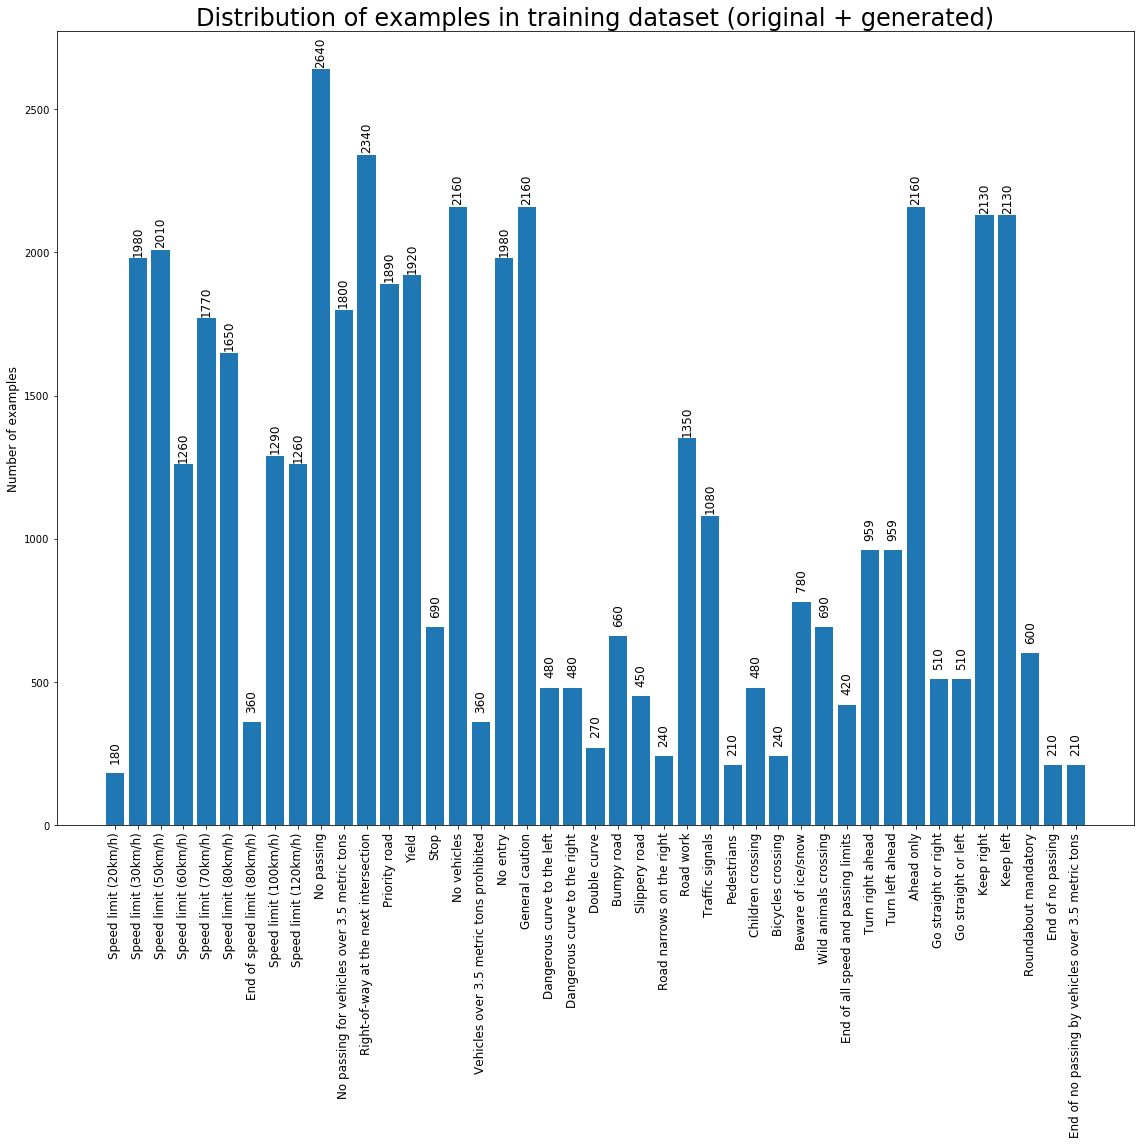

In [7]:
# Load datasets
datasets = np.load('traffic_signs_data/datasets.npz')

# Split datasets
X_train = datasets['X_train']
y_train = datasets['y_train']
X_valid = datasets['X_valid']
y_valid = datasets['y_valid']
X_test = datasets['X_test']
y_test = datasets['y_test']

print('Number of training examples (original + generated) =', len(X_train))

# Load file containing class IDs and sign names
signnames = np.genfromtxt('signnames.csv', dtype = ['i2', 'U50'], delimiter = ',', names = True)

# Count number of examples per class ID in training set
examples = [len(np.argwhere(y_train == classid)) for classid in signnames['ClassId']]

# Plot bar chart distribution of examples in training dataset
fig, ax = plt.subplots(figsize = (16, 16))

ax.bar(signnames['ClassId'], examples)
ax.set_title('Distribution of examples in training dataset (original + generated)', fontsize = 24)
ax.set_xticks(signnames['ClassId'])
ax.set_xticklabels(signnames['SignName'], fontsize = 12, rotation = 'vertical')
ax.set_ylabel('Number of examples', fontsize = 12)

for patch, example in zip(ax.patches, examples):
    ax.text(patch.get_x() + patch.get_width()/2, patch.get_height() + 80,
            example, fontsize = 12, rotation = 'vertical', ha = 'center')

plt.tight_layout()

### Model Architecture

In [8]:
# Creates weight variables by assigning a starting value from the normal distribution
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, mean = 0, stddev = 0.1))

# Creates bias variables by assigning a starting value of 0
def bias(depth):
    return tf.Variable(tf.zeros(depth))

# Convolution operation followed by a non-linear activation
def convolution(x, W, b):
    c = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID') + b
    return tf.nn.relu(c)

# Inception module: 1x1 dimensionality reductions followed by 3x3 and 5x5 convolution operations in parallel with a
# separate 1x1 convolution and max pooling operation, finished off with a non-linear activation
def inception(x, W, b):
    c1x1 = tf.nn.conv2d(x, W[0], strides=[1, 1, 1, 1], padding='SAME') + b[0]
    c1x1_3x3 = tf.nn.relu(tf.nn.conv2d(x, W[1], strides=[1, 1, 1, 1], padding='SAME') + b[1])
    c1x1_5x5 = tf.nn.relu(tf.nn.conv2d(x, W[2], strides=[1, 1, 1, 1], padding='SAME') + b[2])
    c3x3 = tf.nn.conv2d(c1x1_3x3, W[3], strides=[1, 1, 1, 1], padding='SAME') + b[3]
    c5x5 = tf.nn.conv2d(c1x1_5x5, W[4], strides=[1, 1, 1, 1], padding='SAME') + b[4]
    maxpool = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    maxpool_1x1 = tf.nn.conv2d(maxpool, W[5], strides=[1, 1, 1, 1], padding='SAME') + b[5]
    return tf.nn.relu(tf.concat(3, [c1x1, c3x3, c5x5, maxpool_1x1]))

# Fully connected layer followed by a non-linear activation
def fully_connected(x, W, b):
    fc = tf.matmul(x, W) + b
    return tf.nn.relu(fc)

def LeNetMod(x, keep_prob):

    # Parameters: Number of channels (depths)
    d0 = 1
    d1 = 16
    d2 = 32
    d3i = 16
    d3 = 32
    d4 = 1600
    d5 = 43

    # Parameters: 5x5 convolution layer 1
    c1_W = weight([5, 5, d0, d1])
    c1_b = bias(d1)
    
    # Parameters: 5x5 convolution layer 2
    c2_W = weight([5, 5, d1, d2])
    c2_b = bias(d2)
    
    # Parameters: Inception module
    i1_W = [weight([1, 1, d2, d3]),
            weight([1, 1, d2, d3i]),
            weight([1, 1, d2, d3i]),
            weight([3, 3, d3i, d3]),
            weight([5, 5, d3i, d3]),
            weight([1, 1, d2, d3])]
    
    i1_b = [bias(d3),
            bias(d3i),
            bias(d3i),
            bias(d3),
            bias(d3),
            bias(d3)]
    
    # Parameters: Fully connected layer
    fc1_W = weight([5*5*d3*4, d4])
    fc1_b = bias(d4)
    
    # Parameters: Output layer
    fc2_W = weight([d4, d5])
    fc2_b = bias(d5)
    
    # 5x5 convolution layer 1: Input (32x32x1), Output (28x28x16)
    c1 = convolution(x, c1_W, c1_b)
    # Max pooling: Input (28x28x16), Output (14x14x16)
    c1 = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Convolution layer 2: Input (14x14x16), Output (10x10x32)
    c2 = convolution(c1, c2_W, c2_b)
    # Max pooling: Input (10x10x32), Output (5x5x32)
    c2 = tf.nn.max_pool(c2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Inception module: Input (5x5x32), Output (5x5x128)
    i1 = inception(c2, i1_W, i1_b)
    i1 = tf.nn.dropout(i1, keep_prob)
    
    #Flattening: Input (5x5x128), Output (3200)
    fc0 = flatten(i1)

    # Fully connected layer: Input (3200), Output (1600)
    fc1 = fully_connected(fc0, fc1_W, fc1_b)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Output layer: Input (1600), Output(43)
    return tf.matmul(fc1, fc2_W) + fc2_b

In [9]:
# Batch variables
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# Dropout variable
keep_prob = tf.placeholder(tf.float32)

# One hot encoding of class IDs
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

In [21]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.0002

logits = LeNetMod(x, keep_prob) # Run model architecture
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y) # Calculate probability of error
loss_operation = tf.reduce_mean(cross_entropy) # Calculate mean probability of error
optimizer = tf.train.AdamOptimizer(learning_rate) # Create optimizer
# Reduce mean probability of error by optimizing weights and biases
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size] # Create batches
        # Feed batches into evaluation pipeline
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x)) # Batch accuracy
    return total_accuracy / num_examples # Epoch accuracy

### Training, Validation, & Testing

### Training & Validation

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print('Training...')
    print()
    
    for i in range(epochs):
        start = time.time() # Start timer
        X_train, y_train = shuffle(X_train, y_train) # Shuffle training dataset
        for offset in range(0, num_examples, batch_size):
            # Create batches
            batch_x, batch_y = X_train[offset:offset + batch_size], y_train[offset:offset + batch_size]
            # Feed batches into training pipeline
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.40})
        stop = time.time() # Stop timer
        
        training_accuracy = evaluate(X_train, y_train) # Calculate model accuracy for epoch on training dataset
        validation_accuracy = evaluate(X_valid, y_valid) # Calculate model accuracy for epoch on validation dataset
        
        print('Epoch {}'.format(i+1))
        print('Training Time = {:.3f} s'.format(stop - start))
        print('Training Accuracy = {:.3f}'.format(training_accuracy))
        print('Validation Accuracy = {:.3f}'.format(validation_accuracy))
        print()
        
    saver.save(sess, './lenetmod')
    print('Model saved')

Training...

Epoch 1
Training Time = 102.529 s
Training Accuracy = 0.770
Validation Accuracy = 0.682

Epoch 2
Training Time = 102.332 s
Training Accuracy = 0.901
Validation Accuracy = 0.811

Epoch 3
Training Time = 128.853 s
Training Accuracy = 0.951
Validation Accuracy = 0.872

Epoch 4
Training Time = 102.373 s
Training Accuracy = 0.968
Validation Accuracy = 0.903

Epoch 5
Training Time = 102.283 s
Training Accuracy = 0.977
Validation Accuracy = 0.917

Epoch 6
Training Time = 145.905 s
Training Accuracy = 0.983
Validation Accuracy = 0.924

Epoch 7
Training Time = 110.302 s
Training Accuracy = 0.988
Validation Accuracy = 0.935

Epoch 8
Training Time = 114.742 s
Training Accuracy = 0.991
Validation Accuracy = 0.940

Epoch 9
Training Time = 105.593 s
Training Accuracy = 0.991
Validation Accuracy = 0.944

Epoch 10
Training Time = 109.832 s
Training Accuracy = 0.994
Validation Accuracy = 0.949

Epoch 11
Training Time = 109.068 s
Training Accuracy = 0.995
Validation Accuracy = 0.951

Epoch 

### Testing

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test) # Calculate model accuracy on test dataset
    
    print('Test Accuracy = {:.3f}'.format(test_accuracy))

Test Accuracy = 0.955


---

## Step 3: Test Model on New Images

### Load Images

In [25]:
# Load file containing class IDs and sign names
signnames = np.genfromtxt('signnames.csv', dtype = ['i2', 'U50'], delimiter = ',', names = True)

# Get new image
sign = mpimg.imread('traffic_sign_images/02.jpg')

# Create empty array for traffic sign images and array containing traffic sign class IDs
signs = np.empty([0, sign.shape[0], sign.shape[1], sign.shape[2]], dtype = sign.dtype)
classids = np.array([2, 3, 11, 12, 27, 34, 38, 40])

# Fill empty array with traffic sign images
for filename in os.listdir('traffic_sign_images'):
    if filename.endswith('.jpg'):
        filepath = os.path.join('traffic_sign_images/', filename)
        signs = np.append(signs, [mpimg.imread(filepath)], axis = 0)

# Pre-process traffic sign images
signs_pp = preprocess(signs)

### Predict Classes

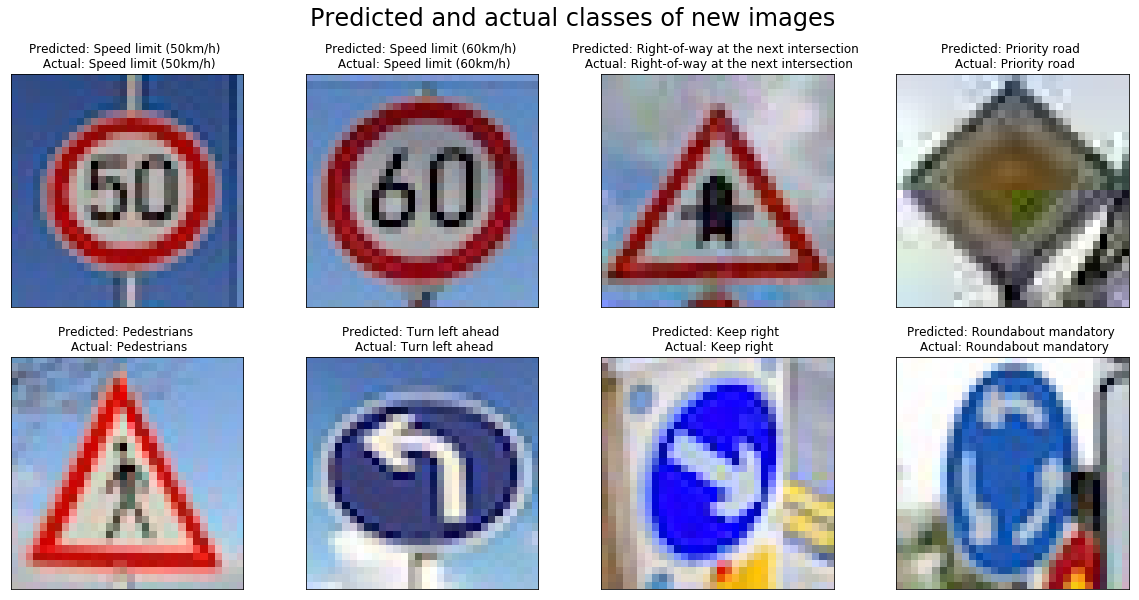

In [26]:
classifier = tf.argmax(logits, axis = 1) # Determine class ID of highest probability

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Feed new images into classifier pipeline
    predictions = sess.run(classifier, feed_dict={x: signs_pp, keep_prob: 1.0})

# Plot new images with predicted and actual classes
fig, axes = plt.subplots(2, 4, figsize = (16, 8))

fig.suptitle('Predicted and actual classes of new images', fontsize = 24, y = 1.04)

for ax, index in zip(axes.flat, np.arange(classids.size)):
    ax.imshow(signs[index])
    ax.set_title('Predicted: {} \n Actual: {}'.
                 format(signnames['SignName'][predictions[index]],
                        signnames['SignName'][classids[index]]), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### Analyze Performance

Accuracy of model on new images = 1.000 

Class: Speed limit (50km/h) 
Precision score = 1.000 
Recall score = 1.000 

Class: Speed limit (60km/h) 
Precision score = 1.000 
Recall score = 1.000 

Class: Right-of-way at the next intersection 
Precision score = 1.000 
Recall score = 1.000 

Class: Priority road 
Precision score = 1.000 
Recall score = 1.000 

Class: Pedestrians 
Precision score = 1.000 
Recall score = 1.000 

Class: Turn left ahead 
Precision score = 1.000 
Recall score = 1.000 

Class: Keep right 
Precision score = 1.000 
Recall score = 1.000 

Class: Roundabout mandatory 
Precision score = 1.000 
Recall score = 1.000 



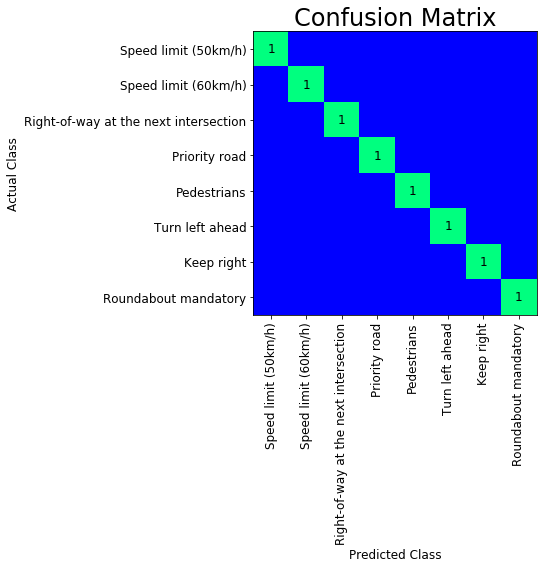

In [27]:
accuracy = accuracy_score(classids, predictions) # Calculate accuracy of model
precisions = precision_score(classids, predictions, average = None) # Calculate precision for each class
recalls = recall_score(classids, predictions, average = None) # Calculate recall for each class
con_matrix = confusion_matrix(classids, predictions) # 

print('Accuracy of model on new images = {:.3f} \n'.format(accuracy))

for classid, precision, recall in zip(classids, precisions, recalls):
    print('Class: {} \nPrecision score = {:.3f} \nRecall score = {:.3f} \n'.
          format(signnames['SignName'][classid], precision, recall))

# Plot confusion matrix
fig, ax = plt.subplots(figsize = (8, 8))

ax.imshow(con_matrix, cmap = 'winter')
ax.set_title('Confusion Matrix', fontsize = 24)
ax.set_xticks(np.arange(classids.size))
ax.set_xticklabels(signnames['SignName'][predictions], fontsize = 12, rotation = 'vertical')
ax.set_yticks(np.arange(classids.size))
ax.set_yticklabels(signnames['SignName'][classids], fontsize = 12)
ax.set_xlabel('Predicted Class', fontsize = 12)
ax.set_ylabel('Actual Class', fontsize = 12)

for row, col in zip(np.arange(con_matrix.shape[0]), np.arange(con_matrix.shape[1])):
    ax.text(row, col, con_matrix[row][col], fontsize = 12, ha = 'center', va = 'center')
    
plt.tight_layout()

### Top 5 Softmax Probabilities

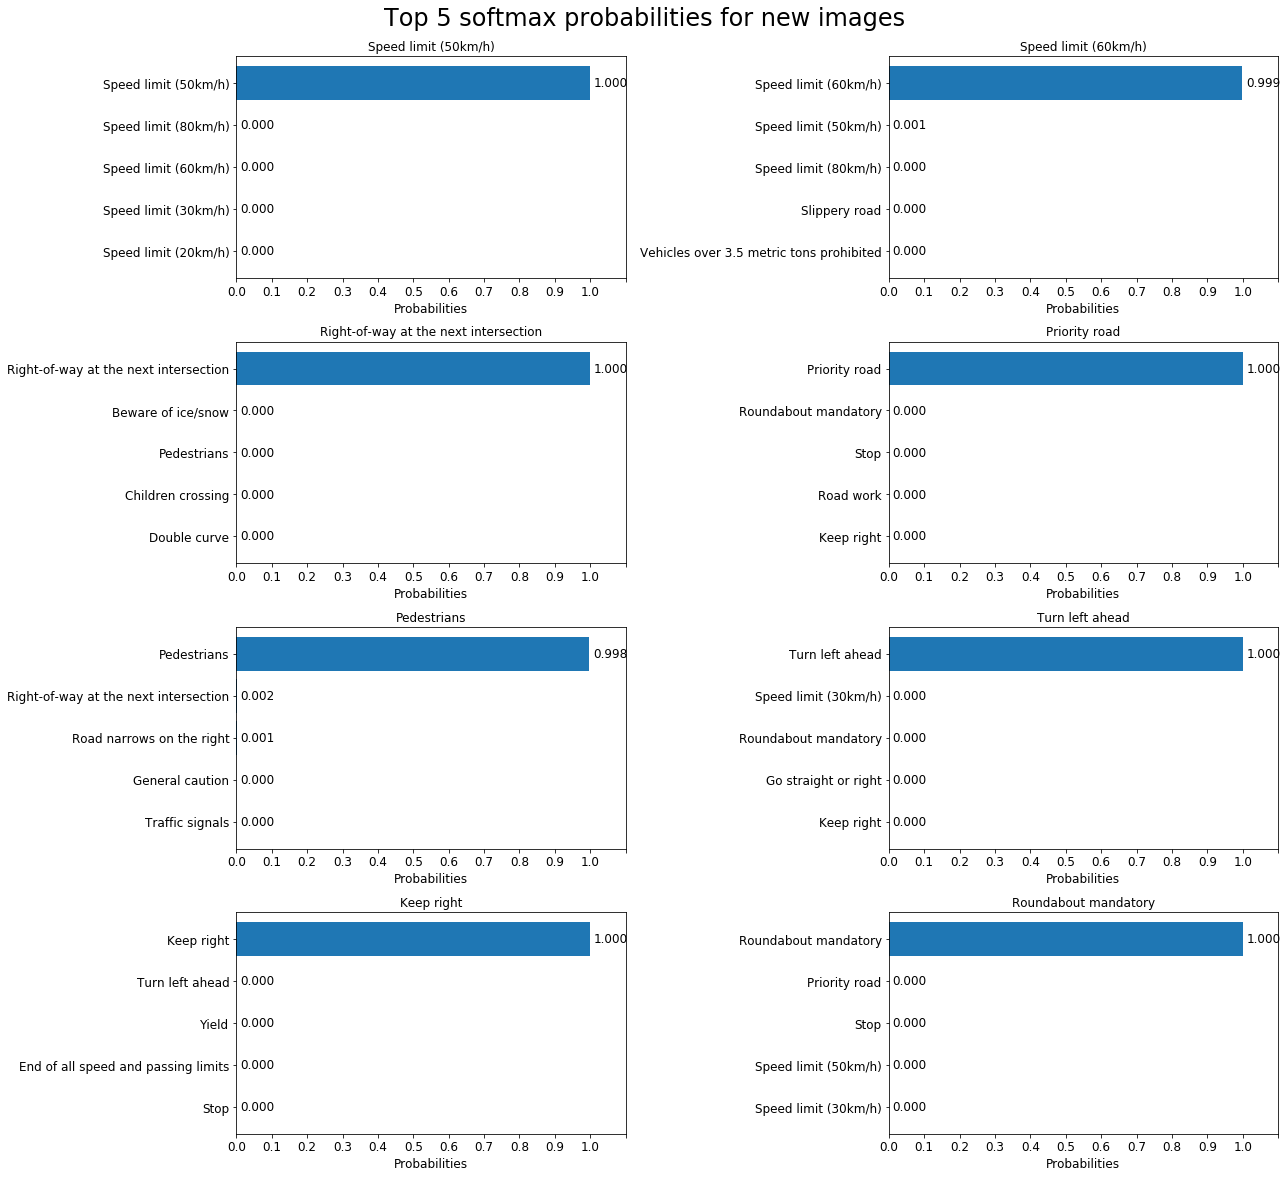

In [28]:
softmax = tf.nn.softmax(logits)
top_softmax = tf.nn.top_k(softmax, k = 5) # Calculate top 5 softmax probabilities

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Feed new images into probability pipeline
    probabilities = sess.run(top_softmax, feed_dict={x: signs_pp, y: classids, keep_prob: 1.0})

# Plot bar chart of top 5 softmax probabilities
fig, axes = plt.subplots(4, 2, figsize = (18, 16))

fig.suptitle('Top 5 softmax probabilities for new images', fontsize = 24, y = 1.02)

for ax, index in zip(axes.flat, np.arange(classids.size)):
    ax.barh(np.arange(5), probabilities[0][index])
    ax.set_title(signnames['SignName'][classids[index]], fontsize = 12)
    ax.set_xticks(np.arange(0, 1.2, .1))
    ax.set_xticklabels(np.arange(0,1.1,.1), fontsize = 12)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(signnames['SignName'][probabilities[1][index]], fontsize = 12)
    ax.invert_yaxis()
    ax.set_xlabel('Probabilities', fontsize = 12)
    for patch, probability in zip(ax.patches, probabilities[0][index]):
        ax.text(patch.get_width() + 0.01, patch.get_y() + patch.get_height()/2,
                '{:.3f}'.format(probability), fontsize = 12, va = 'center')
    
plt.tight_layout()